
Name: Rahmani Dibansa

Date: 23rd of August 2022

Description:
    This contains my comments on how I understand the data pipeline

Reference(s):

    ACMSIGGRAPH. SIGGRAPH Now | Hands-on Workshop: Machine Learning and Neural Networks – Lecture 5

    Retrieved from: https://www.youtube.com/watch?v=PwChjCRkKyU&list=PLUPhVMQuDB_b2kcOooEduedthcBH53mvC&index=5



    Additional comments:
      - So I understand datapipeline as a way to optimize the program. This optimization is done by creating functions that will only be called when needed


In [3]:
# Import the necessary packages
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import skimage

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Use the available datset provided by tensorflow
import tensorflow_datasets as tfds
merced_builder = tfds.builder('uc_merced')

# If the dataset is nowhere to be found, download the dataset
merced_builder.download_and_prepare()

In [5]:
# Display the information about the dataset
print(merced_builder.info)


tfds.core.DatasetInfo(
    name='uc_merced',
    full_name='uc_merced/2.0.0',
    description="""
    UC Merced is a 21 class land use remote sensing image dataset, with 100 images
    per class. The images were manually extracted from large images from the USGS
    National Map Urban Area Imagery collection for various urban areas around the
    country. The pixel resolution of this public domain imagery is 0.3 m.
    
    While most images are 256x256 pixels, there are 44 images with different shape.
    """,
    homepage='http://weegee.vision.ucmerced.edu/datasets/landuse.html',
    data_path='~/tensorflow_datasets/uc_merced/2.0.0',
    file_format=tfrecord,
    download_size=317.07 MiB,
    dataset_size=238.63 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=21),
    }),
    supervised_keys=('image', 'label'),
    disa

In [7]:
# Display the shape and data type of the dataset
f = merced_builder.info.features['image']
print(f)


Image(shape=(None, None, 3), dtype=tf.uint8)


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


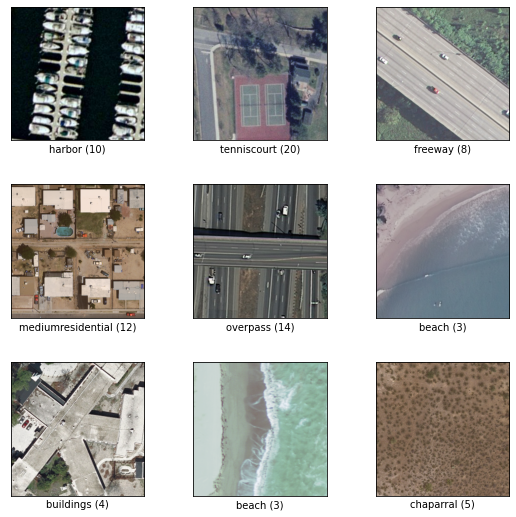

In [8]:
# get the data as a tensorflow dataset
datasets = merced_builder.as_dataset()

# Take the training part of the dataset
full_ds = datasets['train']

# Display some of the data inside the dataset
fig = tfds.show_examples(merced_builder.info, full_ds)

In [10]:
# add gaussian noise to image
# note: this returns the noisy image as well as the original image
# The noise that will be added will depend on the standard deviation
# However, if the standard deviation is not given as an input to the
# function, use the default std dev 0.1
def add_noise(original, std_dev=0.1):
    noise = tf.random.normal(shape=tf.shape(original), mean=0.0, stddev=std_dev, dtype=tf.float32)
    noisy = tf.add(original, noise)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0) # adding noise might make values > 1.0
    # return both the noisy and the normal image
    tensor_tuple = (noisy, original)
    return tensor_tuple

In [11]:
# These are the parameters for the patch width and height
PATCH_WIDTH = 128
PATCH_HEIGHT = 128

# extracts patches of given size from the image
def extract_patches(example, patch_width=PATCH_HEIGHT, patch_height=PATCH_HEIGHT):
  img = example['image']
  # Convert the image to a tensor float
  img = tf.image.convert_image_dtype(img, tf.float32)

  # The size pertains to how large the patch will be
  #
  # The strides is how long should the jump be after every patch
  # For this case, the stride will be equal to the size of the patch
  #
  # As such, there will be no overlapping.
  # But, it was discussed in the lecture that the patches can be
  # overlapped depending on how you want to set it.
  # By having less strides, there will be more overlapping.
  #
  # As for padding, I understood it as a way to generate patches
  # once it hits the corners or any of the sides
  patches = tf.image.extract_patches([img], 
     sizes=[1, patch_height, patch_width, 1], 
     strides=[1, patch_height, patch_width, 1],
     rates=[1, 1, 1, 1],
     padding='SAME')
  
  # So we need to reshape the tensor
  img_tensor = tf.reshape(patches, [-1, patch_height, patch_width, 3])
  return tf.data.Dataset.from_tensor_slices(img_tensor)

In [12]:
# Now compute for the training size
# In this case it will be 70 percent of the 2100
TRAIN_SIZE = int(2100*0.7)

# Take the training data 
train_ds = full_ds.take(TRAIN_SIZE)

# take the test data
test_ds = full_ds.skip(TRAIN_SIZE)

In [13]:
# prep dataset for training
# Here we will be applying the extract patches function
# on the train data set
#
# We will also be generate the image with noise
# using the add noise function.
# 
# The output of the add noise function will be a tuple
# containing the original image as well as the noisy
# image
train_ds = train_ds.flat_map(extract_patches)
train_ds = train_ds.map(add_noise)

In [14]:
# prep dataset for testing
# full-size patches in test data, want to test whole images
#
# Exrtact a 256*256 patches on the images of the test data set
# 
# Add in the noise
#
# And set every item as a batch
test_ds = test_ds.flat_map(lambda x: extract_patches(x, 256, 256))
test_ds = test_ds.map(add_noise)
test_ds = test_ds.batch(1) # one item per batch

In [15]:
# Display the test dataset
print(test_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


In [17]:
# Take 5 batches from the training dataset
# and display it
some_patches = train_ds.take(5)
print(some_patches)

<TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None))>


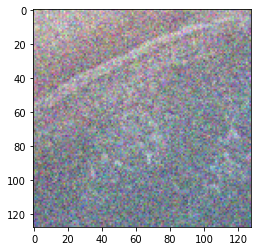

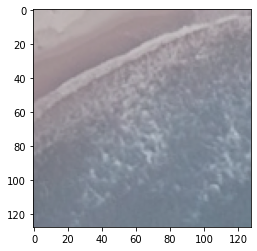

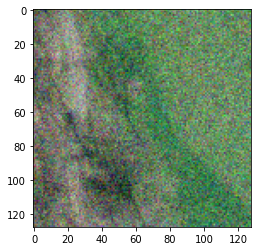

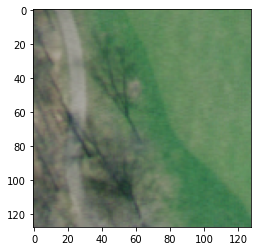

In [20]:
# Display the images on the training dataset
# Shuffle it each time so that a repeat of image
# will not likely occur.
# I changed the parameters on the take function from 5 -> 2
for noisy, orig in train_ds.shuffle(100).take(2): #shuffling before 'take' will give us different images each time
    plt.figure()
    plt.imshow(noisy)
    plt.figure()
    plt.imshow(orig)

In [21]:
# repeat, shuffle and batch
train_ds = train_ds.repeat().shuffle(1024).batch(32)

# prefetch to asynchronously fetch batches while the model is training
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)